In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

import seaborn as sns
import matplotlib.pyplot as plt
from util import util
#from scipy.integrate import odeint
import numpy as np
import pandas as pd
import os
import json
#from skopt.space import Space
#from eml.net.reader import keras_reader
from codecarbon import EmissionsTracker
from sklearn.tree import DecisionTreeRegressor

## Data exploration

Let's have a look at the data produced during benchmark phase, to gather some insights

### Load and combine data

We first load the data and add identifying columns to make it easy to filter and compare the data.

In [6]:
# load data for each combination of algorithm and platform
files = {
    "anticipate_mbp19": "anticipate_mbp19.csv",
    "anticipate_leonardo": "anticipate_leonardo.csv",
    "contingency_mbp19": "contingency_mbp19.csv",
    "contingency_leonardo": "contingency_leonardo.csv"
}

# load each files and add identifiers
dataframes = []
for key, file in files.items():
    algorithm, platform = key.split('_')
    df = util.read_benchmark_file(file)
    df['algorithm'] = algorithm
    df['platform'] = platform
    dataframes.append(df)

# concatenate all dataframes into one for analysis
data = pd.concat(dataframes, ignore_index=True)

### Basic data overview

To get a high-level summary of each metric, we run `.describe()` for statistical insights and `.info()` to check data types

In [7]:
# Lets drop some of the columns
columns = ['nScenarios','nTraces','cpuCount']
data_overview = data.drop(columns=columns)

print(data_overview.describe())
print("="*50)
print(data_overview.info())

         sol(keuro)     time(sec)    memAvg(MB)   memPeak(MB)      CO2e(kg)  \
count  10400.000000  10400.000000  10400.000000  10400.000000  1.040000e+04   
mean     358.864333   1303.906542   9767.433452    288.067621  8.593945e-05   
std       78.470274   2456.130215  14250.336679    278.932854  1.553400e-04   
min      233.130000      1.260000     81.930000      0.120000  9.640000e-09   
25%      313.777500     47.642500    358.072500     28.472500  7.830000e-06   
50%      345.160000    102.170000    626.460000    232.750000  3.130000e-05   
75%      372.060000    789.780000  17519.650000    506.260000  4.830000e-05   
max      813.710000   9984.340000  51772.230000   1202.740000  1.380000e-03   

       CO2eRate(kg/s)  cpuEnergy(kW)  ramEnergy(kW)  totEnergy(kW)  
count    1.040000e+04   10400.000000   1.040000e+04   10400.000000  
mean     2.085635e-06       0.001990   2.354033e-03       0.006746  
std      2.013126e-06       0.002189   2.898436e-03       0.007949  
min      3.0

Notice that the min for memPeak is 0.12. That's because the values for the memory peak consumption recorded on leonardo are strangely low, thus also bringing the average down. It is strange also because in the instance with memPeak 0.12, the average memory is higher, which shouldn’t be possible. The benchmark runs on Leonardo should have been repeated. Unfortunately, the recent weather emergency in Emilia-Romagna caused the interruptions of the HPC services offered by Cineca.

### Categorical analysis

Analyze categorical columns like `algorithm`, `platform`, `country` and `region` to understand the distribution.

In [8]:
# Count distribution for categorical columns
print(data['algorithm'].value_counts())
print(data['platform'].value_counts())
print(data['country'].value_counts())
print(data['region'].value_counts())

contingency    6000
anticipate     4400
Name: algorithm, dtype: int64
mbp19       6000
leonardo    4400
Name: platform, dtype: int64
Canada    5724
Italy     4676
Name: country, dtype: int64
quebec            5724
emilia-romagna    4676
Name: region, dtype: int64


Notice that we "canada" and "quebec" in many entries for the country and region. That's not because i travelled, even though i'd like to. That is something taken from codecarbon, so there should be some problem there when tracking emissions. The problem with these values is that they influence the way in which the carbon footprint is computed. That's because codecarbon uses data relative to the carbon intensity of a given country, so that could change the final result. For example, we have 4.31e-06 as emission rate for italy and 3.00e-08 for canada. Notice that we could also remove this column, since its values are fixed.

### Exploring performance metrics

Since `sol(keuro)`, `time(sec)`, `memAvg(MB)` and `memPeak(MB)` represent performance metrics, visualize and compare them across algorithms and platforms. First, we compare solution cost and time

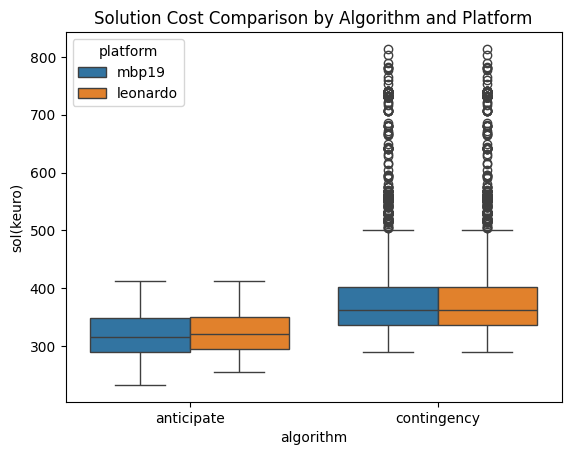

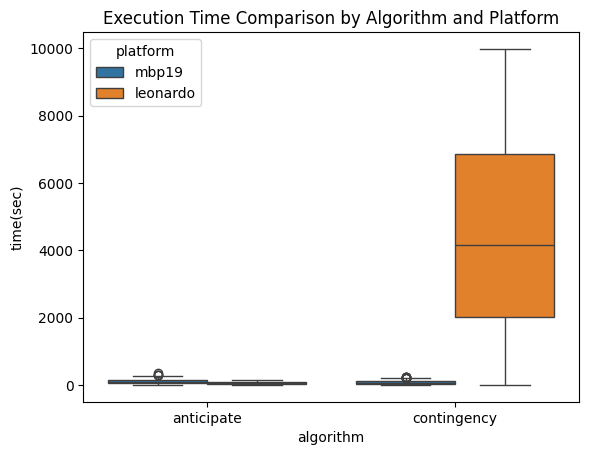

In [9]:
# Solution Cost Comparison by Algorithm and Platform
sns.boxplot(data=data, x='algorithm', y='sol(keuro)', hue='platform')
plt.title('Solution Cost Comparison by Algorithm and Platform')
plt.show()

# Time Required Comparison
sns.boxplot(data=data, x='algorithm', y='time(sec)', hue='platform')
plt.title('Execution Time Comparison by Algorithm and Platform')
plt.show()

We can notice that solution cost is tipycally higher for contingency. While for the execution time, results are a bit strange

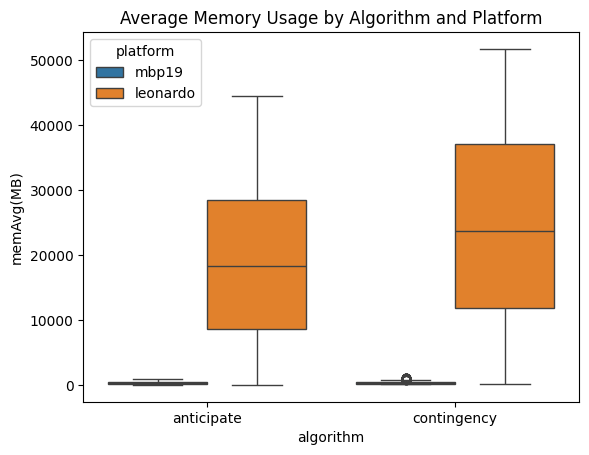

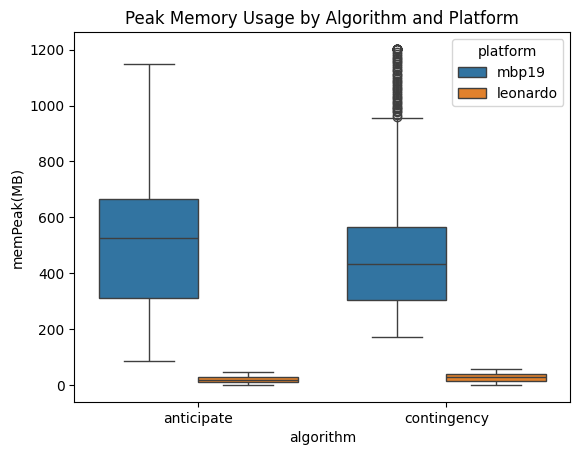

In [10]:
# Average Memory Usage
sns.boxplot(data=data, x='algorithm', y='memAvg(MB)', hue='platform')
plt.title('Average Memory Usage by Algorithm and Platform')
plt.show()

# Peak Memory Usage
sns.boxplot(data=data, x='algorithm', y='memPeak(MB)', hue='platform')
plt.title('Peak Memory Usage by Algorithm and Platform')
plt.show()

### Energy and Emission Analysis

Explore the CO2 emissions `CO2e(kg)` and energy consumption metrics to compare environmental impact across algorithms and platforms

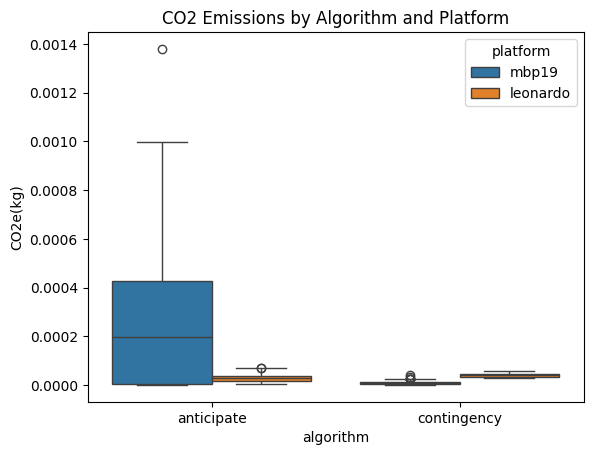

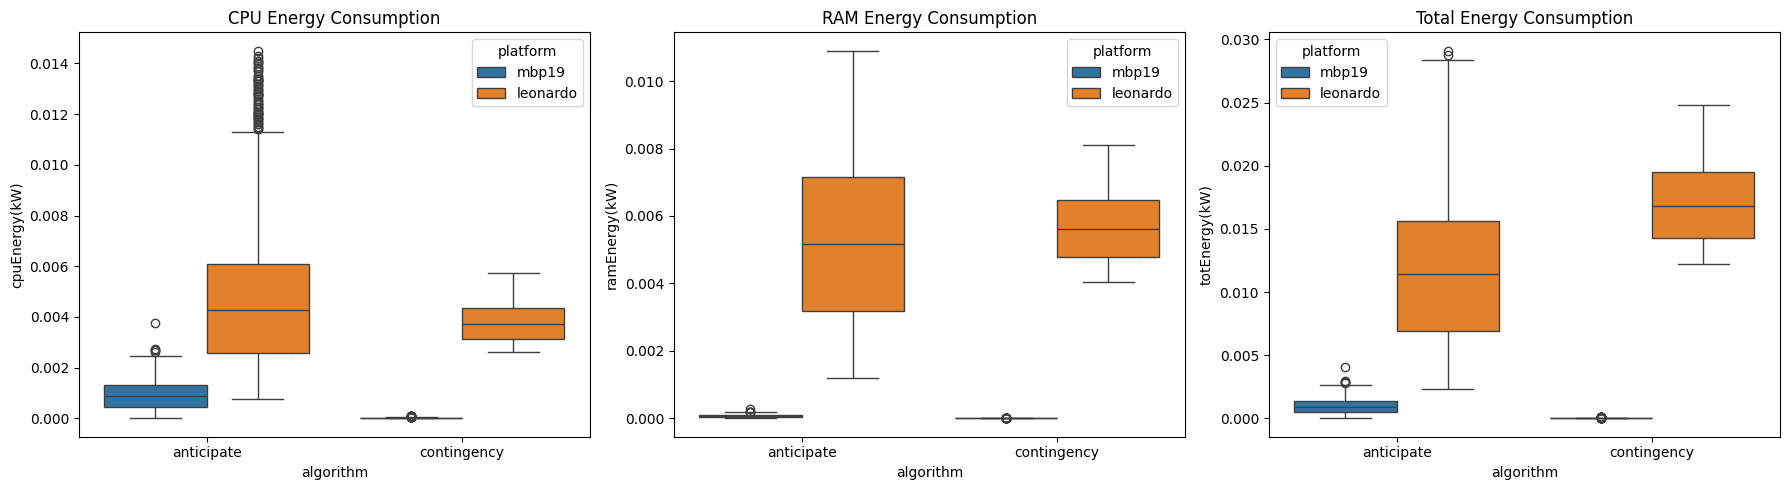

In [11]:
# CO2 Emissions by Algorithm and Platform
sns.boxplot(data=data, x='algorithm', y='CO2e(kg)', hue='platform')
plt.title('CO2 Emissions by Algorithm and Platform')
plt.show()

# Energy Consumption: CPU, RAM, and Total
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=data, x='algorithm', y='cpuEnergy(kW)', hue='platform', ax=axes[0])
axes[0].set_title('CPU Energy Consumption')

sns.boxplot(data=data, x='algorithm', y='ramEnergy(kW)', hue='platform', ax=axes[1])
axes[1].set_title('RAM Energy Consumption')

sns.boxplot(data=data, x='algorithm', y='totEnergy(kW)', hue='platform', ax=axes[2])
axes[2].set_title('Total Energy Consumption')

plt.tight_layout()
plt.show()

### Performance vs. Emissions Correlation

Analyze if there's a correlation between performance and environmental metrics

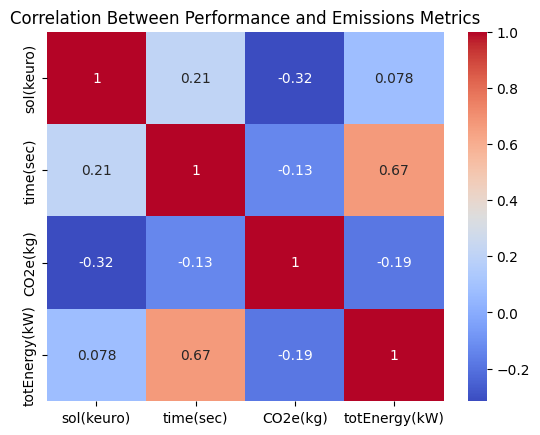

In [12]:
# Correlation matrix for numeric columns
correlation_matrix = data[['sol(keuro)', 'time(sec)', 'CO2e(kg)', 'totEnergy(kW)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Performance and Emissions Metrics')
plt.show()

### Comparison of Core Counts

Check if CPU core count impacts solution time or energy consumption.

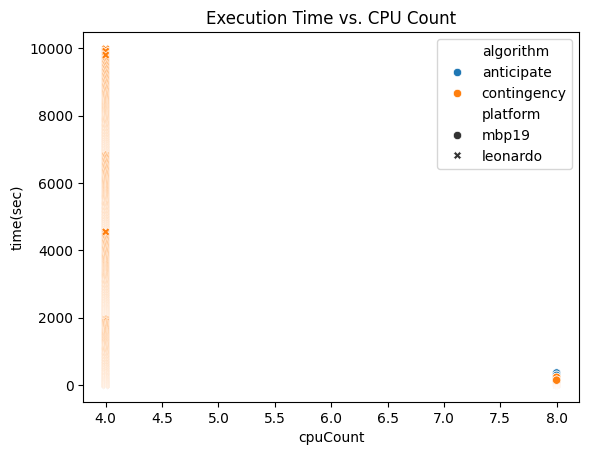

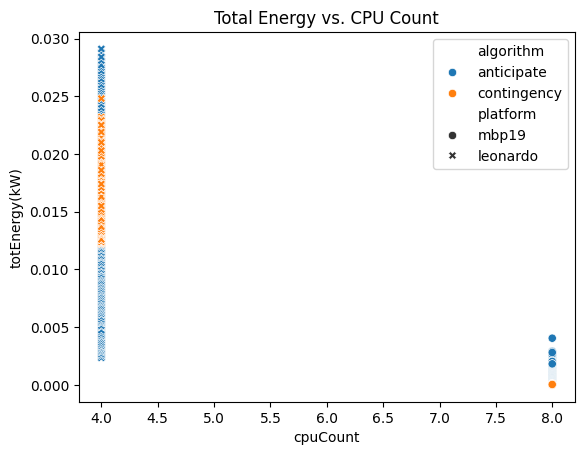

In [13]:
# Execution Time vs. CPU Count
sns.scatterplot(data=data, x='cpuCount', y='time(sec)', hue='algorithm', style='platform')
plt.title('Execution Time vs. CPU Count')
plt.show()

# Total Energy vs. CPU Count
sns.scatterplot(data=data, x='cpuCount', y='totEnergy(kW)', hue='algorithm', style='platform')
plt.title('Total Energy vs. CPU Count')
plt.show()

Before, it is necessary to set a configuration file for each algorithm. That is nothing but a .json for each combination of algorithm and hardware platform containing all the informations about the algorithms name, the hyperparameters and the targets, with indications of the type of variables and eventually upper and lower bounds for them. For example, the following is the configuration file for ANTICIPATE